# Problem Statement :
- Build a english to hindi transliteration model

In [11]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import os
import xml.etree.ElementTree as ET 
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pickle
import nltk
import re
from tqdm import tqdm
import tensorflow as tf

from tensorflow.keras.activations import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from bs4 import BeautifulSoup
import string
from unidecode import unidecode
from gensim.models import KeyedVectors
import fasttext
tf.config.run_functions_eagerly(True)
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 3060 (UUID: GPU-81f6e2eb-490f-a94c-111c-389f658c4c02)


In [12]:
def preprocess(text_data, decont = False):
    def decontracted(phrase):
        # specific
        phrase = re.sub(r"won't", "will not", phrase)
        phrase = re.sub(r"can\'t", "can not", phrase)
        # general
        phrase = re.sub(r"n\'t", " not", phrase)
        phrase = re.sub(r"\'re", " are", phrase)
        phrase = re.sub(r"\'s", " is", phrase)
        phrase = re.sub(r"\'d", " would", phrase)
        phrase = re.sub(r"\'ll", " will", phrase)
        phrase = re.sub(r"\'t", " not", phrase)
        phrase = re.sub(r"\'ve", " have", phrase)
        phrase = re.sub(r"\'m", " am", phrase)
        return phrase
    sentance = text_data
    for char in string.punctuation:
        sentance = sentance.replace(char, ' ').strip()
    sentance = sentance.replace('\u200d', '')
    if decont:
        sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = sentance.lower().strip()
    return sentance

In [14]:
data = []
for file in os.listdir('data'):
    tree = ET.parse(f'data/{file}') 
    root = tree.getroot() 
    data += [(x[0].text, x[1].text) for x in root]
data = pd.DataFrame(data, columns = ['English', 'Hindi'])
data['English'] = data['English'].apply(preprocess)
data['English'] = data['English'].apply(unidecode)
data['Hindi'] = data['Hindi'].apply(preprocess)
data1 = data[(data['Hindi'].str.split().apply(len)<=3) & (data['English'].str.split().apply(len)<=3)]

In [15]:
data = []
tree = ET.parse(f'data/NEWS2018_M-EnHi_trn.xml') 
root = tree.getroot() 
data += [(x[0].text, x[1].text) for x in root]
data = pd.DataFrame(data, columns = ['English', 'Hindi'])
data['English'] = data['English'].apply(preprocess)
data['English'] = data['English'].apply(unidecode)
data['Hindi'] = data['Hindi'].apply(preprocess)
data2 = data[(data['Hindi'].str.split().apply(len)<=3) & (data['English'].str.split().apply(len)<=3)]

In [16]:
data = pd.concat([data1, data2], 0)
data.drop_duplicates(inplace = True)

In [17]:
data['Hindi'] = '\t ' + data['Hindi'] + ' \n'

In [18]:
def load_glove_vectors(glove_file):
    embeddings = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings
english_embeddings = load_glove_vectors(r"E:/Project_Crown_Grab/embeddings/glove.6B.300d.txt")

In [19]:
hindi_embeddings = KeyedVectors.load_word2vec_format(r"E:\IDM\hi\hi.vec", binary=False)

In [20]:
from collections import Counter

In [21]:
from joblib import Parallel, delayed

In [22]:
max_sequence_length = max(data['English'].apply(len).max(), data['Hindi'].apply(len).max())
max_sequence_length

36

In [23]:
def tokenize_and_pad_sequences(texts, max_sequence_length):
    tokenizer = Tokenizer(char_level=True, lower=False)
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')
    return padded_sequences, tokenizer

english_sequences, english_tokenizer = tokenize_and_pad_sequences(data['English'], max_sequence_length)
hindi_sequences, hindi_tokenizer = tokenize_and_pad_sequences(data['Hindi'], max_sequence_length)

In [24]:
target_data = np.zeros_like(hindi_sequences)
target_data[:, 0:max_sequence_length-1] = hindi_sequences[:, 1:max_sequence_length]
target_data = np.expand_dims(target_data, -1)

In [25]:
embedding_size = 300

In [26]:
def create_embedding_matrix(tokenizer, word2vec_model, embedding_size):
    embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_size))
    for word, index in tokenizer.word_index.items():
        if word in word2vec_model:
            embedding_matrix[index] = word2vec_model[word]
    return embedding_matrix
english_embedding_matrix = create_embedding_matrix(english_tokenizer, english_embeddings, embedding_size)
hindi_embedding_matrix = create_embedding_matrix(hindi_tokenizer, hindi_embeddings, embedding_size)

In [27]:
input_vocab_size = len(english_tokenizer.word_index) + 1
output_vocab_size = len(hindi_tokenizer.word_index) + 1
lstm_size = 256
encoder_inputs = Input(shape=(max_sequence_length,))
encoder_embedding = Embedding(input_vocab_size, embedding_size, mask_zero=True, weights=[english_embedding_matrix],
                              trainable=False)(encoder_inputs)
encoder_dropout = Dropout(0.9)(encoder_embedding)
encoder_lstm = LSTM(lstm_size, return_state=True, return_sequences=True)
_, encoder_state_h, encoder_state_c = encoder_lstm(encoder_dropout)
encoder_states = [encoder_state_h, encoder_state_c]

decoder_inputs = Input(shape=(max_sequence_length,))
decoder_embedding = Embedding(output_vocab_size, embedding_size, mask_zero=True, weights=[hindi_embedding_matrix],
                              trainable=False)(decoder_inputs)
decoder_dropout = Dropout(0.9)(decoder_embedding)
decoder_lstm = LSTM(lstm_size, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_dropout, initial_state=encoder_states)
decoder_dense = Dense(output_vocab_size, activation='softmax')
outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], outputs)


In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 36)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 36)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 36, 300)      8400        ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 36, 300)      21300       ['input_2[0][0]']                
                                                                                              

In [22]:
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps=100000, 
                                                             decay_rate=0.96, staircase=True)
model.compile(optimizer=tf.keras.optimizers.Adam(initial_learning_rate), loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [23]:
epochs = 1000
batch_size = 1024
early = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)
check = tf.keras.callbacks.ModelCheckpoint('model_weights.h5', save_weights_only = True, save_best_only = True,
                                           verbose = True)
model.fit([english_sequences, hindi_sequences], target_data, epochs=epochs, batch_size=batch_size, validation_split=0.1,
          callbacks=[check, early])

Epoch 1/1000
11/12 [==========================>...] - ETA: 0s - loss: 1.2296 - accuracy: 0.1810
Epoch 00001: val_loss improved from inf to 1.07455, saving model to model_weights.h5
12/12 [==============================] - 2s 54ms/step - loss: 1.2170 - accuracy: 0.1829 - val_loss: 1.0745 - val_accuracy: 0.2278
Epoch 2/1000
11/12 [==========================>...] - ETA: 0s - loss: 0.9913 - accuracy: 0.2866
Epoch 00002: val_loss improved from 1.07455 to 0.99072, saving model to model_weights.h5
12/12 [==============================] - 1s 53ms/step - loss: 0.9866 - accuracy: 0.2896 - val_loss: 0.9907 - val_accuracy: 0.3129
Epoch 3/1000
11/12 [==========================>...] - ETA: 0s - loss: 0.8965 - accuracy: 0.3448
Epoch 00003: val_loss improved from 0.99072 to 0.91278, saving model to model_weights.h5
12/12 [==============================] - 1s 53ms/step - loss: 0.8932 - accuracy: 0.3456 - val_loss: 0.9128 - val_accuracy: 0.3643
Epoch 4/1000
11/12 [==========================>...] - ETA: 

Epoch 27/1000
11/12 [==========================>...] - ETA: 0s - loss: 0.4565 - accuracy: 0.6101
Epoch 00027: val_loss improved from 0.52191 to 0.51591, saving model to model_weights.h5
12/12 [==============================] - 1s 52ms/step - loss: 0.4569 - accuracy: 0.6103 - val_loss: 0.5159 - val_accuracy: 0.5673
Epoch 28/1000
12/12 [==============================] - ETA: 0s - loss: 0.4488 - accuracy: 0.6160
Epoch 00028: val_loss improved from 0.51591 to 0.50716, saving model to model_weights.h5
12/12 [==============================] - 1s 52ms/step - loss: 0.4488 - accuracy: 0.6160 - val_loss: 0.5072 - val_accuracy: 0.5766
Epoch 29/1000
11/12 [==========================>...] - ETA: 0s - loss: 0.4426 - accuracy: 0.6199
Epoch 00029: val_loss improved from 0.50716 to 0.50068, saving model to model_weights.h5
12/12 [==============================] - 1s 53ms/step - loss: 0.4409 - accuracy: 0.6207 - val_loss: 0.5007 - val_accuracy: 0.5807
Epoch 30/1000
12/12 [==============================]

Epoch 53/1000
11/12 [==========================>...] - ETA: 0s - loss: 0.3213 - accuracy: 0.7138
Epoch 00053: val_loss improved from 0.39289 to 0.38543, saving model to model_weights.h5
12/12 [==============================] - 1s 52ms/step - loss: 0.3205 - accuracy: 0.7147 - val_loss: 0.3854 - val_accuracy: 0.6683
Epoch 54/1000
11/12 [==========================>...] - ETA: 0s - loss: 0.3168 - accuracy: 0.7177
Epoch 00054: val_loss improved from 0.38543 to 0.38085, saving model to model_weights.h5
12/12 [==============================] - 1s 53ms/step - loss: 0.3165 - accuracy: 0.7178 - val_loss: 0.3808 - val_accuracy: 0.6704
Epoch 55/1000
12/12 [==============================] - ETA: 0s - loss: 0.3130 - accuracy: 0.7219
Epoch 00055: val_loss improved from 0.38085 to 0.37972, saving model to model_weights.h5
12/12 [==============================] - 1s 52ms/step - loss: 0.3130 - accuracy: 0.7219 - val_loss: 0.3797 - val_accuracy: 0.6737
Epoch 56/1000
11/12 [==========================>...]

Epoch 80/1000
12/12 [==============================] - ETA: 0s - loss: 0.2514 - accuracy: 0.7726
Epoch 00080: val_loss improved from 0.32954 to 0.32661, saving model to model_weights.h5
12/12 [==============================] - 1s 52ms/step - loss: 0.2514 - accuracy: 0.7726 - val_loss: 0.3266 - val_accuracy: 0.7179
Epoch 81/1000
12/12 [==============================] - ETA: 0s - loss: 0.2502 - accuracy: 0.7737
Epoch 00081: val_loss improved from 0.32661 to 0.32559, saving model to model_weights.h5
12/12 [==============================] - 1s 53ms/step - loss: 0.2502 - accuracy: 0.7737 - val_loss: 0.3256 - val_accuracy: 0.7194
Epoch 82/1000
11/12 [==========================>...] - ETA: 0s - loss: 0.2482 - accuracy: 0.7748
Epoch 00082: val_loss did not improve from 0.32559
12/12 [==============================] - 1s 50ms/step - loss: 0.2476 - accuracy: 0.7751 - val_loss: 0.3263 - val_accuracy: 0.7186
Epoch 83/1000
12/12 [==============================] - ETA: 0s - loss: 0.2451 - accuracy: 

Epoch 107/1000
11/12 [==========================>...] - ETA: 0s - loss: 0.2085 - accuracy: 0.8090
Epoch 00107: val_loss improved from 0.30375 to 0.30285, saving model to model_weights.h5
12/12 [==============================] - 1s 52ms/step - loss: 0.2083 - accuracy: 0.8091 - val_loss: 0.3029 - val_accuracy: 0.7366
Epoch 108/1000
12/12 [==============================] - ETA: 0s - loss: 0.2067 - accuracy: 0.8101
Epoch 00108: val_loss did not improve from 0.30285
12/12 [==============================] - 1s 50ms/step - loss: 0.2067 - accuracy: 0.8101 - val_loss: 0.3061 - val_accuracy: 0.7323
Epoch 109/1000
11/12 [==========================>...] - ETA: 0s - loss: 0.2062 - accuracy: 0.8111
Epoch 00109: val_loss did not improve from 0.30285
12/12 [==============================] - 1s 49ms/step - loss: 0.2057 - accuracy: 0.8113 - val_loss: 0.3034 - val_accuracy: 0.7339
Epoch 110/1000
12/12 [==============================] - ETA: 0s - loss: 0.2040 - accuracy: 0.8111
Epoch 00110: val_loss did n

Epoch 135/1000
11/12 [==========================>...] - ETA: 0s - loss: 0.1758 - accuracy: 0.8363
Epoch 00135: val_loss did not improve from 0.29029
12/12 [==============================] - 1s 50ms/step - loss: 0.1758 - accuracy: 0.8361 - val_loss: 0.2908 - val_accuracy: 0.7511
Epoch 136/1000
12/12 [==============================] - ETA: 0s - loss: 0.1735 - accuracy: 0.8387
Epoch 00136: val_loss improved from 0.29029 to 0.28988, saving model to model_weights.h5
12/12 [==============================] - 1s 52ms/step - loss: 0.1735 - accuracy: 0.8387 - val_loss: 0.2899 - val_accuracy: 0.7528
Epoch 137/1000
12/12 [==============================] - ETA: 0s - loss: 0.1732 - accuracy: 0.8384
Epoch 00137: val_loss did not improve from 0.28988
12/12 [==============================] - 1s 50ms/step - loss: 0.1732 - accuracy: 0.8384 - val_loss: 0.2915 - val_accuracy: 0.7490
Epoch 138/1000
12/12 [==============================] - ETA: 0s - loss: 0.1715 - accuracy: 0.8406
Epoch 00138: val_loss did n

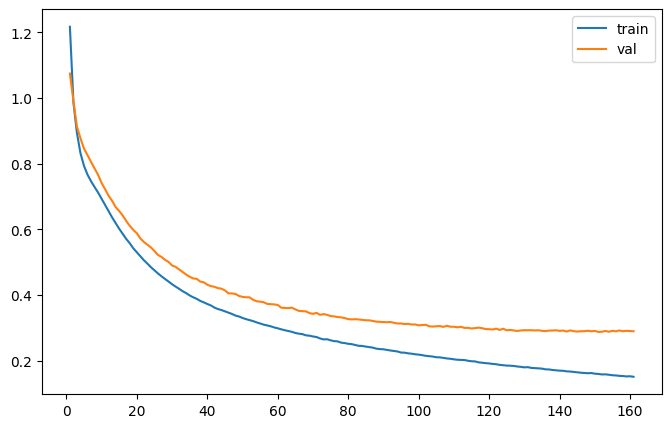

In [24]:
plt.figure(figsize = (8,5))
plt.plot(np.array(model.history.epoch)+1, model.history.history['loss'], label = 'train')
plt.plot(np.array(model.history.epoch)+1, model.history.history['val_loss'], label = 'val')
plt.legend()
plt.show()

In [28]:
model.load_weights('model_weights.h5')

In [26]:
with open('english_tokenizer.pickle', 'wb') as handle:
    pickle.dump(english_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
handle.close()

In [27]:
with open('hindi_tokenizer.pickle', 'wb') as handle:
    pickle.dump(hindi_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
handle.close()

In [29]:
# Encoder model for inference
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder model for inference
decoder_state_input_h = Input(shape=(lstm_size,))
decoder_state_input_c = Input(shape=(lstm_size,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(decoder_dropout, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

In [30]:
def transliterate(input_text, encoder_model, decoder_model, input_tokenizer, output_tokenizer, max_sequence_length):
    input_seq = input_tokenizer.texts_to_sequences([input_text])
    input_seq = pad_sequences(input_seq, maxlen=max_sequence_length, padding='post')

    states_value = encoder_model.predict(input_seq)

    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = output_tokenizer.word_index['\t']

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = output_tokenizer.index_word[sampled_token_index]

        decoded_sentence += sampled_char

        if sampled_char == '\n' or len(decoded_sentence) > max_sequence_length:
            stop_condition = True

        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        states_value = [h, c]

    return decoded_sentence.strip()
input_text = "mera naam ismail hai"
output_text = ' '
for x in input_text.split():
    transliterated_text = transliterate(x, encoder_model, decoder_model, english_tokenizer, hindi_tokenizer, max_sequence_length)
    output_text = output_text + ' ' + transliterated_text
print(output_text.strip())

मेरा नाम इस्माल है


## Final Words:
- With more data I can build more robust and fast model
- If latency is not the issue then we can use BERT, T5.